# Practice Session 2: Machine Learning Pipelines

## Load the Data

The code below loads a dataset consisting of 100 k records of questions and answers from https://stackoverflow.com.

It is a small subset of a much larger dataset published by from https://stackexchange.com/. 

The subset has been downloaded from: https://fullstackml.com/beginners-guide-apache-spark-machine-learning-scenario-with-a-large-input-dataset-1f0c6bc53f8f

The full dataset can be obtained at: https://archive.org/download/stackexchange

### Task 1: Create a DataFrame

Create a Spark SQL DataFrame called `posts` by loading the Parquet File located at `hdfs:///data/posts`. Do not set any options (i.e. use the default). Then print the schema.

In [1]:
posts = spark.read.load('hdfs:///data/posts')
posts.printSchema()

root
 |-- id: long (nullable = true)
 |-- PostTypeId: long (nullable = true)
 |-- CreationDate: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- TagsRaw: string (nullable = true)
 |-- BodyRaw: string (nullable = true)
 |-- ParentId: long (nullable = true)
 |-- AcceptedAnswerId: long (nullable = true)
 |-- Score: long (nullable = true)
 |-- ViewCount: long (nullable = true)
 |-- AnswerCount: long (nullable = true)
 |-- CommentCount: long (nullable = true)
 |-- FavoriteCount: long (nullable = true)



Let's print some contents.

In [2]:
interesting_columns = ['id', 'PostTypeId', 'Title', 'BodyRaw', 'TagsRaw', 'CreationDate']

posts.select(interesting_columns).orderBy('id').show()

+---+----------+--------------------+--------------------+--------------------+--------------------+
| id|PostTypeId|               Title|             BodyRaw|             TagsRaw|        CreationDate|
+---+----------+--------------------+--------------------+--------------------+--------------------+
|  4|         1|When setting a fo...|<p>I want to use ...|<c#><winforms><ty...|2008-07-31T21:42:...|
|  6|         1|Why doesn't the p...|<p>I have an abso...|<html><css><css3>...|2008-07-31T22:08:...|
|  7|         2|                null|<p>An explicit ca...|                null|2008-07-31T22:17:...|
|  9|         1|How do I calculat...|<p>Given a <code>...|<c#><.net><datetime>|2008-07-31T23:40:...|
| 11|         1|How do I calculat...|<p>Given a specif...|      <c#><datediff>|2008-07-31T23:55:...|
| 12|         2|                null|<p>Well, here's h...|                null|2008-07-31T23:56:...|
| 13|         1|Determining a web...|<p>Is there a sta...|<html><browser><t...|2008-08-01T0

## Data Cleaning and Processing

We can see that the posts are categorized by tags. Let us try to proedict tags from the text content of posts.

Text content is found in the `BodyRaw` and the `Title` columns.

But we can see that the data has some problems in the dataset.
* `BodyRaw` contains HTML tags.
* `TagsRaw` contains the tags but they are all enclosed with '<' and '>' characters and stored as a single string.
* Some records do not have any title nor tags but contain `null` values.

The `null` values in `Title` and `TagsRaw` indicate that the posts are not questions but answers or comments. We will have to filter them out later because they have no tags that can be used for learning.

### Task 2: Use User-Defined Functions (UDFs) to clean the records.

Below you can find two normal Python functions:
* `extract_tags` removes the '<' and '>' characters in `TagsRaw` and create a comma-separated list of tags.
* `process_body` removes the HTML markup from the `BodyRaw` values and return only the text content.




1. Create a UDF for each of the two Python functions (http://spark.apache.org/docs/2.1.1/api/python/pyspark.sql.html#pyspark.sql.functions.udf).
1. Create a new DataFrame `posts_processed` with additional columns `Tags` and `Body` containing the processed data (use DataFrame.withColumn: http://spark.apache.org/docs/2.1.1/api/python/pyspark.sql.html#pyspark.sql.DataFrame).
1. Cache `posts_processed`.

In [3]:
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf, from_unixtime, unix_timestamp
from bs4 import BeautifulSoup
import re

def extract_tags(tags_raw):
    if tags_raw is None:
        return None
    else:
        tags_list = []
        for tag in re.sub(r'<|>', ' ', tags_raw).split(' '):
            tag = tag.strip().lower()
            if len(tag) > 0:
                tags_list.append(tag)
        return ','.join(tags_list)
    
    
def process_body(body_raw):
    soup = BeautifulSoup(body_raw, 'html.parser')
    text = soup.get_text().strip()
    lines = text.split('\n')
    return ' '.join(filter(lambda line: len(line) > 0, lines))

# Create UDFs
extract_tags_udf = udf(extract_tags, StringType())
process_body_udf = udf(process_body, StringType())

# Create new columns with processed data.
posts_processed = posts.\
    withColumn('Tags', extract_tags_udf('TagsRaw')).\
    withColumn('Body', process_body_udf('BodyRaw')).\
    withColumn('CreationDate', \
        from_unixtime(\
            unix_timestamp('CreationDate', "yyyy-MM-dd'T'HH:mm:ss.SSS")))

# Cache posts_processed
posts_processed.cache()

DataFrame[id: bigint, PostTypeId: bigint, CreationDate: string, Title: string, TagsRaw: string, BodyRaw: string, ParentId: bigint, AcceptedAnswerId: bigint, Score: bigint, ViewCount: bigint, AnswerCount: bigint, CommentCount: bigint, FavoriteCount: bigint, Tags: string, Body: string]

Let's check the result.

In [4]:
posts_processed.select(['id', 'Title', 'Body', 'Tags', 'CreationDate']).show()
print("There are %d records." % posts_processed.count())

tag_dist = posts_processed.rdd.flatMap(lambda row: [] if row['Tags'] is None else row['Tags'].split(',')).\
    map(lambda tag: (tag, 1)).reduceByKey(lambda t1, t2: t1 + t2)
top_3_tags = tag_dist.sortBy(lambda pair: pair[1], ascending=False).take(3)
print('Top records:\n' + repr(top_3_tags))

+--------+--------------------+--------------------+--------------------+-------------------+
|      id|               Title|                Body|                Tags|       CreationDate|
+--------+--------------------+--------------------+--------------------+-------------------+
|28868603|                null|I solved my probl...|                null|2015-03-05 01:48:17|
|28868604|Sort Different Co...|Scenario: I have ...|sql-server,sql-se...|2015-03-05 01:48:19|
|28868605|                null|Your getInt() met...|                null|2015-03-05 01:48:32|
|28868606|closed unexpected...|In my unity3d and...|android-activity,...|2015-03-05 01:48:37|
|28868607|                null|This problem migh...|                null|2015-03-05 01:48:53|
|28868608|                null|I, too, would rec...|                null|2015-03-05 01:48:53|
|28868609|iCalendar order o...|Is there any rest...|           icalendar|2015-03-05 01:48:54|
|28868610|Django. ImportErr...|This is weird. I ...|django,d

## Feature and Label Extraction

The most frequent tag is `java`. We will attempt to classify text belonging to the `java` tag. We need *features* to learn from and true *labels* that contain the value that we want to classify. 

### Task 3: Create Feature Columns

Create a new DataFrame `labaled_posts` with the following properties:

1. `filter` all posts where `Tags` is null.
1. Use the `concat_ws` (http://spark.apache.org/docs/2.1.1/api/python/pyspark.sql.html#pyspark.sql.functions.concat_ws) and the `lower` (http://spark.apache.org/docs/2.1.1/api/python/pyspark.sql.html#pyspark.sql.functions.lower) functions to create a new feature-column `Text` with the text contents from `Title` and `Body` joined and all characters lower-case.
1. Use the `split` function (http://spark.apache.org/docs/2.1.1/api/python/pyspark.sql.html#pyspark.sql.functions.split) to convert the `Tags` column into an array of tags (instead of a string).
1. Complete the code for the label-column `IsJava` to contain `1.0` if `Tags` contains `java` and `0.0` otherwise. Use the `array_contains` function (http://spark.apache.org/docs/2.1.1/api/python/pyspark.sql.html#pyspark.sql.functions.array_contains).  

In [5]:
from pyspark.sql.functions import array_contains, split, concat_ws, when, count, lower

tag_to_predict = 'java'

# Create a new DataFrame with feature and label columns.
labeled_posts = posts_processed.filter('Tags is not null').\
    withColumn('Text', lower(concat_ws(' ', 'Title', 'Body'))).\
    withColumn('Tags', split('Tags', ',')).\
    withColumn('IsJava', when(array_contains('Tags', tag_to_predict) == True, 1.0).otherwise(0.0))

Let's look at the new columns:

In [6]:
labeled_posts.select('id', 'Text', 'IsJava').show(50)

+--------+--------------------+------+
|      id|                Text|IsJava|
+--------+--------------------+------+
|28868604|sort different co...|   0.0|
|28868606|closed unexpected...|   0.0|
|28868609|icalendar order o...|   0.0|
|28868610|django. importerr...|   0.0|
|28868611|matplotlib.animat...|   0.0|
|28868613|custom listview t...|   0.0|
|28868614|plan comparison c...|   0.0|
|28868617|how can i create ...|   0.0|
|28868620|need help for alg...|   1.0|
|28868621|how to get drawst...|   1.0|
|28868623|assigning freemar...|   0.0|
|28868624|uml comment (in a...|   0.0|
|28868626|asp classic repla...|   0.0|
|28868627|angular cannot re...|   0.0|
|28868629|what is the varia...|   0.0|
|28868632|libgdx: screenuti...|   0.0|
|28868633|program runs only...|   0.0|
|28868635|struggling with p...|   0.0|
|28868636|lazy evaluation -...|   0.0|
|28868638|why does ruby arr...|   0.0|
|28868640|is it best practi...|   0.0|
|28868642|php create javasc...|   0.0|
|28868644|changing datagr

### Task 4: Create Test Set and Training Set

Use the DataFrame.randomSplit() method to split the records in `all_tagged_posts` into 70% training and 30% test set.
http://spark.apache.org/docs/2.1.1/api/python/pyspark.sql.html#pyspark.sql.DataFrame

In [7]:
# Make sure there are no null values.
all_tagged_posts = labeled_posts.filter('IsJava is not null')

# Split the date into training and test set.
(training, test) = all_tagged_posts.randomSplit([0.7, 0.3])

In [8]:
# Check the class distribution.
training.groupBy('IsJava').agg(count('IsJava').alias('training_samples')).show()
test.groupBy('IsJava').agg(count('IsJava').alias('test_samples')).show()

+------+----------------+
|IsJava|training_samples|
+------+----------------+
|   0.0|           20808|
|   1.0|            2076|
+------+----------------+

+------+------------+
|IsJava|test_samples|
+------+------------+
|   0.0|        9016|
|   1.0|         859|
+------+------------+



## Create a MLlib Pipeline for LogisticRegression Classifier


### Task 5: Create and fit a Pipeline:

1. A `Tokenizer` to split `Text` into `Words`: http://spark.apache.org/docs/2.1.1/api/python/pyspark.ml.html#pyspark.ml.feature.Tokenizer
1. A `StopWordsRemover` to filter english stop words from `Words`: http://spark.apache.org/docs/2.1.1/api/python/pyspark.ml.html#pyspark.ml.feature.StopWordsRemover
1. A term frequency feature extractor `HashingTF` (http://spark.apache.org/docs/2.1.1/api/python/pyspark.ml.html#pyspark.ml.feature.HashingTF) to create term frequencies from the filtered words. Set the `features` parameter as given in the code below.
1. A `IDF` feature extractor to normalize the term frequencies by inverse document frequency (TF-IDF, http://spark.apache.org/docs/2.1.1/api/python/pyspark.ml.html#pyspark.ml.feature.IDF). Set the `minFrequencies` parameter as given in the code below.
1. Finally, add a `LogisticRegression` estimator to the pipeline. Use `IsJava` as the `labelCol` and use the given `epochs` and `reg` arguments.
1. `fit()` the pipeline with the `training` data set.

In [9]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import Tokenizer, HashingTF, IDF, StopWordsRemover

features = 512
epochs = 30
reg = 0.02
min_doc_frequency = 5

tokenizer = Tokenizer(inputCol='Text', outputCol='Words')
stopwordRemover = StopWordsRemover(inputCol=tokenizer.getOutputCol(), outputCol='filtered')
hashingTF = HashingTF(numFeatures=features, inputCol=stopwordRemover.getOutputCol(), outputCol='tf')
idf = IDF(inputCol=hashingTF.getOutputCol(), outputCol='Features', minDocFreq=min_doc_frequency)
lr = LogisticRegression(maxIter=epochs, regParam=reg, featuresCol='Features', labelCol='IsJava', predictionCol='Prediction')

pipeline = Pipeline(stages=[tokenizer, stopwordRemover, hashingTF, idf, lr])

# Fit the pipeline and store the model.
model = pipeline.fit(training)

Let's check our model with an arbitrary example text.

In [10]:
testTitle = 'I need help with Java'
testBody = '''How to write a Hello World program 
and run it in the JVM.
And how to package my program as a JAR File?
Do I need to put all code into a .java file?
Do I need to use System.out.println ?'''
testText = testTitle + " " + testBody
testDF = spark.createDataFrame([(1.0, testText.lower())], schema=["IsJava", "Text"])
result = model.transform(testDF)

result.printSchema()
result.select('probability', 'Prediction').take(1)

root
 |-- IsJava: double (nullable = true)
 |-- Text: string (nullable = true)
 |-- Words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tf: vector (nullable = true)
 |-- Features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- Prediction: double (nullable = true)



[Row(probability=DenseVector([0.7956, 0.2044]), Prediction=0.0)]

## Evaluate (test) the Model

The above example does not look very good. Let us check how good we are over all the test set.

### Task 6: Classify the test set records and evaluate the model

1. Use the model's `transform()` method to predict the `java` tag for the records in the `test` set.
2. Create a `BinaryClassificationEvaluator` and `evaluate()` the results (calculate the ROC_AUC): http://spark.apache.org/docs/2.1.1/api/python/pyspark.ml.html#pyspark.ml.evaluation.BinaryClassificationEvaluator

In [11]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Predict the tag for the test-set
result = model.transform(test)

# Evaluate the model by ROC-AUC.
evaluator = BinaryClassificationEvaluator(rawPredictionCol=lr.getRawPredictionCol(), labelCol=lr.getLabelCol())
print('AUC: %g' % evaluator.evaluate(result))

AUC: 0.799617


Text(0,0.5,'True Positive Rate')

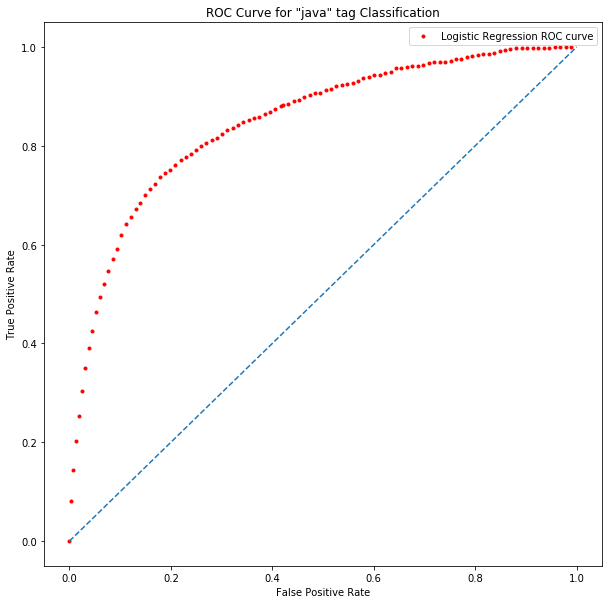

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 10)

# Let's plot the ROC-curve.
roc_data = model.stages[-1].summary.roc.toPandas()

plt.plot(roc_data['FPR'][:-2], roc_data['TPR'][:-2], 'r.', label='Logistic Regression ROC curve')
plt.plot([0., 1.], [0., 1.], linestyle='--')
plt.legend()
plt.title('ROC Curve for "' + tag_to_predict + '" tag Classification')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

## (Bonus) Can we improve?

What do you think can be changed to improve the results? 
Do you see a problem?

[Row(probability=DenseVector([0.4322, 0.5678]), Prediction=1.0)]
AUC: 0.799089


Text(0,0.5,'True Positive Rate')

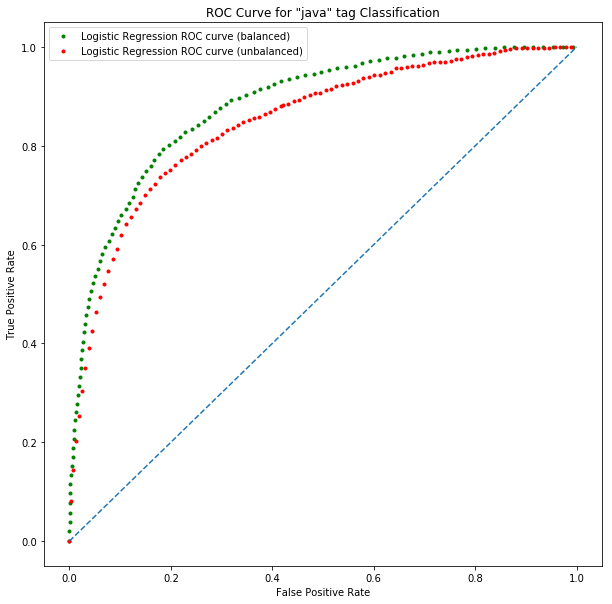

In [13]:
from pyspark.sql.functions import rand

java_posts = all_tagged_posts.filter('IsJava = 1.0')
not_java = all_tagged_posts.filter('IsJava = 0.0')

positive_samples = java_posts.count()

balanced_data_set = java_posts.union(not_java.orderBy(rand()).limit(positive_samples))

(balanced_train, balanced_test) = balanced_data_set.randomSplit([0.7, 0.3])

balanced_model = pipeline.fit(balanced_train)
balanced_result = balanced_model.transform(balanced_test)

print(balanced_model.transform(testDF).select('probability', 'Prediction').take(1))

print('AUC: %g' % evaluator.evaluate(balanced_result))

roc_data_b = balanced_model.stages[-1].summary.roc.toPandas()

plt.rcParams['figure.figsize'] = (10, 10)
plt.plot(roc_data_b['FPR'][:-2], roc_data_b['TPR'][:-2], 'g.', label='Logistic Regression ROC curve (balanced)')
plt.plot(roc_data['FPR'][:-2], roc_data['TPR'][:-2], 'r.', label='Logistic Regression ROC curve (unbalanced)')
plt.plot([0., 1.], [0., 1.], linestyle='--')
plt.legend()
plt.title('ROC Curve for "' + tag_to_predict + '" tag Classification')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

## Classify into more than two classes.

Let's say we want to classify the `Score` of a post into three classes (low=`0`, average=`1`, high=`2`) using the post meta-data `ViewCount`, `AnswerCount`, `CommentCount`, `FavoriteCount`, and whether there is an accepted answer (`AcceptedAnswerId`).

We will use another algorithm for this: A Decisiion Tree classifier.

## Clean Data and Create new Features

In [14]:
from pyspark.sql.functions import isnull, col

labeled_posts_dt = labeled_posts.withColumn('HasNoAcceptedAnswer', isnull('AcceptedAnswerId')).\
    withColumn('Score', col('Score').cast('double')). \
    fillna({'FavoriteCount': 0,
            'CommentCount': 0,
            'AnswerCount': 0,
            'ViewCount': 0,
            'Score': 0.})
    
labeled_posts_dt.printSchema()

root
 |-- id: long (nullable = true)
 |-- PostTypeId: long (nullable = true)
 |-- CreationDate: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- TagsRaw: string (nullable = true)
 |-- BodyRaw: string (nullable = true)
 |-- ParentId: long (nullable = true)
 |-- AcceptedAnswerId: long (nullable = true)
 |-- Score: double (nullable = false)
 |-- ViewCount: long (nullable = false)
 |-- AnswerCount: long (nullable = false)
 |-- CommentCount: long (nullable = false)
 |-- FavoriteCount: long (nullable = false)
 |-- Tags: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- Body: string (nullable = true)
 |-- Text: string (nullable = false)
 |-- IsJava: double (nullable = false)
 |-- HasNoAcceptedAnswer: boolean (nullable = false)



## Create a MLlib Pipeline for DecisionTreeClassifier

### Task 7: Create a new Pipeline

1. Create and fit a `QuantileDiscretizer` estimator and `fit()` it with the entire data set. Make it write the new `Score` classes (labels) into a new column `Popularity`. https://spark.apache.org/docs/2.1.1/api/python/pyspark.ml.html#pyspark.ml.feature.QuantileDiscretizer
1. Create a `VectorAssembler` to combine all feature columns (`ViewCount`, `AnswerCount`, `CommentCount`, `FavoriteCount`, `HasNoAcceptedAnswer`) into a single column `rawFeatures`. https://spark.apache.org/docs/2.1.1/api/python/pyspark.ml.html#pyspark.ml.feature.VectorAssembler
1. Use a `VectorIndexer` with `maxCategories=20` on `rawFeatures` and write the result to a new column `features`. This will try to find categories in the data. https://spark.apache.org/docs/2.1.1/api/python/pyspark.ml.html#pyspark.ml.feature.VectorIndexer
1. Create a `DecisionTreeClassifier` (https://spark.apache.org/docs/2.1.1/api/python/pyspark.ml.html#pyspark.ml.classification.DecisionTreeClassifier) that classifies `Popularity` (labels) using the `features` column.
1. Assemble everything in a pipeline in the right order.

In [15]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import VectorIndexer, VectorAssembler, QuantileDiscretizer


label_discretizer = QuantileDiscretizer(numBuckets=3, inputCol='Score', outputCol='Popularity').\
    fit(labeled_posts_dt)

feature_assembler = VectorAssembler(inputCols=['ViewCount', \
    'AnswerCount', 'CommentCount', 'FavoriteCount', 'HasNoAcceptedAnswer'], \
    outputCol='rawFeatures')
feature_indexer = VectorIndexer(inputCol='rawFeatures', outputCol='features', maxCategories=20)

dt = DecisionTreeClassifier(labelCol='Popularity', featuresCol='features')

dt_pipeline = Pipeline(stages=[label_discretizer, feature_assembler, feature_indexer, dt])

## Split Test and Training Data and `fit()` the Model 

In [16]:
(training_dt, test_dt) = labeled_posts_dt.randomSplit([0.7, 0.3])

model_dt = dt_pipeline.fit(training_dt)

## Predict the `Popularity` of the Test Set Records

In [17]:
result_dt = model_dt.transform(test_dt)

## Evaluate the Model Accuracy

### Task 8: Create a `MulticlassClassificationEvaluator` to evaluate the results.

Make sure that it calculates the `accuracy` metric.

https://spark.apache.org/docs/2.1.1/api/python/pyspark.ml.html#pyspark.ml.evaluation.MulticlassClassificationEvaluator

In [18]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Let's look at the predicted values.
result_dt.select('Score', 'Popularity', 'prediction').sample(True, 0.4).show(50)

# Are we more or less balanced?
result_dt.groupBy('Popularity').agg(count('Popularity').alias('Count')).show()

# Calculate the 'Accuracy' metric.
evaluator_dt = MulticlassClassificationEvaluator(predictionCol=dt.getPredictionCol(), \
                labelCol=dt.getLabelCol(), metricName='accuracy')
print(evaluator_dt.getMetricName() + (": %g" % evaluator_dt.evaluate(result_dt)))

+-----+----------+----------+
|Score|Popularity|prediction|
+-----+----------+----------+
|  0.0|       1.0|       1.0|
| -1.0|       0.0|       1.0|
|  0.0|       1.0|       1.0|
|  2.0|       2.0|       1.0|
|  0.0|       1.0|       1.0|
|  1.0|       2.0|       1.0|
|  0.0|       1.0|       1.0|
| -3.0|       0.0|       1.0|
|  0.0|       1.0|       1.0|
| -1.0|       0.0|       1.0|
| -1.0|       0.0|       1.0|
|  0.0|       1.0|       1.0|
|  0.0|       1.0|       1.0|
|  0.0|       1.0|       1.0|
|  0.0|       1.0|       1.0|
|  2.0|       2.0|       2.0|
|  0.0|       1.0|       1.0|
|  1.0|       2.0|       1.0|
|  0.0|       1.0|       1.0|
|  0.0|       1.0|       1.0|
|  0.0|       1.0|       1.0|
|  0.0|       1.0|       1.0|
|  0.0|       1.0|       1.0|
| -1.0|       0.0|       1.0|
|  0.0|       1.0|       1.0|
|  1.0|       2.0|       1.0|
|  1.0|       2.0|       1.0|
|  1.0|       2.0|       2.0|
|  1.0|       2.0|       1.0|
|  1.0|       2.0|       1.0|
|  1.0|   